In [3]:
import os
import sys
sys.path.append('..')

# metropolis

prior mean: 0, prior std: 1
Posterior mean: 0.35, Posterior std: 0.61


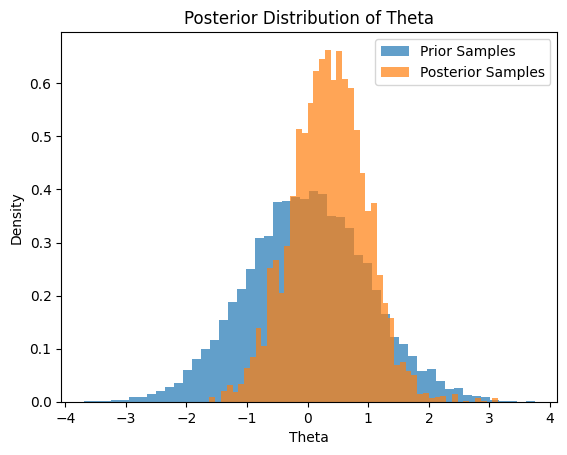

In [5]:
import torch
import torch.distributions as dist

# Define the prior: Normal(mu, sigma)
def prior(theta, mu=0.0, sigma=1.0):
    return dist.Normal(mu, sigma).log_prob(theta)

# Define the likelihood: Bernoulli(f(theta)), where f(theta) = sigmoid(theta)
def likelihood(theta, y, f=None):
    if f is None:
        f_theta = torch.sigmoid(theta)  # f(theta) = logistic function
    else:
        f_theta = f(theta)
    return y * torch.log(f_theta) + (1 - y) * torch.log(1 - f_theta)

# Define the target posterior (up to proportionality)
def log_posterior(theta, y, mu=0.0, sigma=1.0):
    return likelihood(theta, y).sum() + prior(theta, mu, sigma)

# Metropolis-Hastings algorithm
def metropolis_hastings(y, num_samples=10000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=1.0):
    samples = []
    theta = torch.tensor(0.0)  # Initial value of theta
    current_log_posterior = log_posterior(theta, y, mu, sigma)

    for i in range(num_samples + burn_in):
        # Propose a new theta' using a symmetric proposal distribution
        proposal = torch.normal(theta, proposal_std)  # Gaussian proposal q(theta'|theta)

        # Compute log-posterior for the proposal
        proposed_log_posterior = log_posterior(proposal, y, mu, sigma)

        # Compute the acceptance probability
        acceptance_prob = torch.exp(proposed_log_posterior - current_log_posterior)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            theta = proposal
            current_log_posterior = proposed_log_posterior

        # Store the sample after burn-in
        if i >= burn_in:
            samples.append(theta.item())

    return torch.tensor(samples)

# Example usage
# Observations (y): binary data from a Bernoulli distribution
y = torch.tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.float32)

# Run Metropolis-Hastings
samples = metropolis_hastings(y, num_samples=5000, burn_in=1000, mu=0.0, sigma=1.0, proposal_std=0.5)

mean, std = samples.mean(), samples.std()

print(f"prior mean: 0, prior std: 1")
print(f"Posterior mean: {mean:.2f}, Posterior std: {std:.2f}")

# Analyze and visualize results
import matplotlib.pyplot as plt
# plot prior samples
plt.hist(dist.Normal(0, 1).sample((10000,)).numpy(), bins=50, density=True, alpha=0.7, label='Prior Samples')

# Plot the posterior samples
plt.hist(samples.numpy(), bins=50, density=True, alpha=0.7, label='Posterior Samples')
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()


# variational inference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
            
            # Predicted y
            y_pred = X @ theta #function of  X=(x,y) and theta sampled from variational distribution q_lambda
            
            # Log likelihood
            log_likelihood = likelihood(y, y_pred, noise_std) # function of y, y_pred and noise_std as observation model of the pomdp
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist

# Synthetic data for Bayesian linear regression
torch.manual_seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features
true_theta = torch.tensor([2.0, -1.0])
y = X @ true_theta + 0.1 * torch.randn(100)
print(X.shape, true_theta.shape)

# Initialize variational distribution
variational_dist = VariationalDistribution(dim=2)

# Train with BBVI
trained_dist = bbvi(X, y, variational_dist, num_epochs=100, num_samples=100, lr=0.05)

# Output trained variational parameters
print(f"Variational Mean: {trained_dist.mu.detach().numpy()}")
print(f"Variational Log Std: {trained_dist.log_sigma.detach().numpy()}")


torch.Size([100, 2]) torch.Size([2])
Epoch 100, ELBO: -112.0604
Variational Mean: [ 2.0206351 -0.9992352]
Variational Log Std: [-1.8429017 -1.9003012]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

def plot_distributions(variational_dist, prior_mu, prior_sigma):
    """
    Plots the prior and variational distributions in 2D.

    Parameters:
    - variational_dist: VariationalDistribution instance.
    - prior_mu: Tensor (2,) representing the mean of the prior.
    - prior_sigma: Tensor (2,) representing the diagonal standard deviation of the prior.
    """
    assert prior_mu.shape[0] == 2, "This function only works for input_dim=2"
    
    # Convert prior mean and std to NumPy arrays
    prior_mu = prior_mu.detach().cpu().numpy()
    prior_sigma = prior_sigma.detach().cpu().numpy()
    prior_cov = np.diag(prior_sigma**2)
    
    # Define the variational mean and covariance
    variational_mu = variational_dist.mu.detach().cpu().numpy()
    variational_sigma = torch.exp(variational_dist.log_sigma).detach().cpu().numpy()
    variational_cov = np.diag(variational_sigma**2)
    
    # Define grid for plotting
    x, y = np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.stack([X, Y], axis=-1)
    
    # Compute prior distribution pdf
    prior_pdf = np.exp(
        -0.5 * np.einsum("...i,ij,...j->...", pos - prior_mu, np.linalg.inv(prior_cov), pos - prior_mu)
    )
    prior_pdf /= np.sqrt((2 * np.pi)**2 * np.linalg.det(prior_cov))  # Normalize
    
    # Compute variational distribution pdf
    var_pdf = np.exp(
        -0.5 * np.einsum("...i,ij,...j->...", pos - variational_mu, np.linalg.inv(variational_cov), pos - variational_mu)
    )
    var_pdf /= np.sqrt((2 * np.pi)**2 * np.linalg.det(variational_cov))  # Normalize
    
    # Plot the contours
    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, prior_pdf, levels=8, cmap='Blues', alpha=0.7)
    plt.contour(X, Y, var_pdf, levels=8, cmap='Reds', alpha=0.7)
    plt.scatter(prior_mu[0], prior_mu[1], c='blue', marker='x', label='Prior Mean')
    plt.scatter(variational_mu[0], variational_mu[1], c='red', marker='x', label='Variational Mean')
    
    # Add labels
    plt.title("Prior and Variational Distribution (2D)")
    plt.xlabel("Theta_1")
    plt.ylabel("Theta_2")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# # Parameters for prior and variational distribution
# input_dim = 2
# prior_mu = torch.zeros(input_dim)  # Prior mean
# prior_sigma = torch.ones(input_dim)  # Prior standard deviation

# # Initialize the variational distribution
# variational_dist = VariationalDistribution(input_dim)

# # Update variational distribution with some arbitrary values (e.g., after training)
# variational_dist.mu.data = torch.tensor([1.0, -0.5])  # Example mean
# variational_dist.log_sigma.data = torch.log(torch.tensor([0.7, 0.4]))  # Example log std dev

# Plot the prior and variational distribution
plot_distributions(variational_dist, true_theta[0], true_theta[1])



IndexError: tuple index out of range

# my VI

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Define the model and likelihood
def likelihood(y, y_pred, noise_std):
    return Normal(y_pred, noise_std).log_prob(y).sum()

# Define the prior
def prior(theta):
    return Normal(0, 1).log_prob(theta).sum()

# Variational distribution (q_lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_sigma = nn.Parameter(torch.zeros(dim))
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def log_prob(self, theta):
        sigma = torch.exp(self.log_sigma)
        return Normal(self.mu, sigma).log_prob(theta).sum()

# BBVI Training Loop
def bbvi(X, y, variational_dist, num_epochs=5000, num_samples=10, lr=0.01):
    optimizer = optim.Adam(variational_dist.parameters(), lr=lr)
    noise_std = 0.1  # Observation noise

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Monte Carlo approximation of ELBO
        elbo = 0
        for _ in range(num_samples):
            # Sample theta ~ q_lambda
            theta = variational_dist.sample().squeeze() 
                        
            # Log likelihood p(x|theta)
            log_likelihood = obs_model(x,theta,y)
            
            # Log prior
            log_prior = prior(theta)
            
            # Log variational density
            log_q = variational_dist.log_prob(theta)
            
            # ELBO term
            elbo += log_likelihood + log_prior - log_q
        
        elbo /= num_samples  # Average over samples
        
        # Maximize ELBO (minimize negative ELBO)
        loss = -elbo
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, ELBO: {elbo.item():.4f}")

    return variational_dist


# vae inference style


In [6]:
import torch.functional as F
import torch.nn as nn
import torch
class VAE(nn.Module):
    def __init__(self, obs_model):
        super(VAE, self).__init__()

        
        self.obs_model = obs_model
        self.obs_model.eval()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        # this should be replaced by the observation model p(x|z)
        return self.obs_model(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar




# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(recon_x, x, reduction='sum') #

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # replace with KL for arbitrary prior

    return BCE + KLD

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
obs_model = nn.Sequential(
    nn.Linear(20, 400),
    nn.ReLU(),
    nn.Linear(400, 784),
    nn.Sigmoid()
).to(device)

In [13]:
model = VAE(obs_model=obs_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)